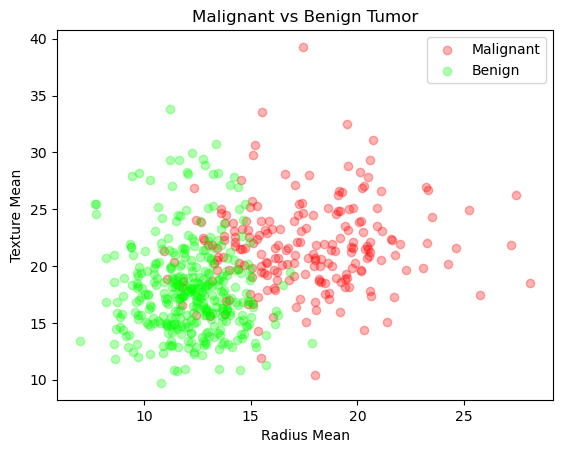

In [14]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import mlrose_hiive
from mlrose_hiive.runners import NNGSRunner
from mlrose_hiive import NeuralNetwork, GeomDecay

dataset = pd.read_csv("data.csv")

np.random.seed(42)

# Data Visualization
def plot_data(df):
    M = df[df.diagnosis == "M"]
    B = df[df.diagnosis == "B"]
    plt.title("Malignant vs Benign Tumor")
    plt.xlabel("Radius Mean")
    plt.ylabel("Texture Mean")
    plt.scatter(M.radius_mean, M.texture_mean, color="red", label="Malignant", alpha=0.3)
    plt.scatter(B.radius_mean, B.texture_mean, color="lime", label="Benign", alpha=0.3)
    plt.legend()
    plt.show()

plot_data(dataset)

In [15]:
# Data Preprocessing
def preprocess_data(df):
    df = df.drop(["id", "Unnamed: 32"], axis=1)
    # Encode the target variable
    df.diagnosis = [1 if i == "M" else 0 for i in df.diagnosis]
    x = df.drop(["diagnosis"], axis=1)
    y = df.diagnosis.values
    return x, y

x, y = preprocess_data(dataset)

# Split the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42, stratify=y)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardize the datasets
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

from mlrose_hiive import NeuralNetwork, GeomDecay
from sklearn.metrics import accuracy_score


# Define Neural Network
nn_model = NeuralNetwork(
    hidden_nodes=[10, 5],
    activation='relu',
    algorithm='random_hill_climb', # placeholder, will change for each algorithm
    max_iters=3000,
    bias=True,
    is_classifier=True,
    learning_rate=0.001,
    early_stopping=True,
    clip_max=5,
    max_attempts=100,
    random_state=42,
    curve=True
)


In [16]:
# Now, you can train the neural network and predict on the validation set
# Train with Random Hill Climbing
nn_model.set_params(algorithm='random_hill_climb')
nn_model.fit(x_train_scaled, y_train)

# Predict on validation set
y_valid_pred_rhc = nn_model.predict(x_valid_scaled)
accuracy_rhc = accuracy_score(y_valid, y_valid_pred_rhc)

In [17]:
#Train with Simulated Annealing
# Define decay schedule
schedule = GeomDecay()

# Train with Simulated Annealing
nn_model.set_params(algorithm='simulated_annealing', schedule=schedule)
nn_model.fit(x_train_scaled, y_train)

# Predict on validation set
y_valid_pred_sa = nn_model.predict(x_valid_scaled)
accuracy_sa = accuracy_score(y_valid, y_valid_pred_sa)


In [19]:
# Train with Genetic Algorithm
nn_model.set_params(algorithm='genetic_alg', pop_size=200, mutation_prob=0.1)
nn_model.fit(x_train_scaled, y_train)

# Predict on validation set
y_valid_pred_ga = nn_model.predict(x_valid_scaled)
accuracy_ga = accuracy_score(y_valid, y_valid_pred_ga)

Training using random_hill_climb...
Training using simulated_annealing...
Training using genetic_alg...


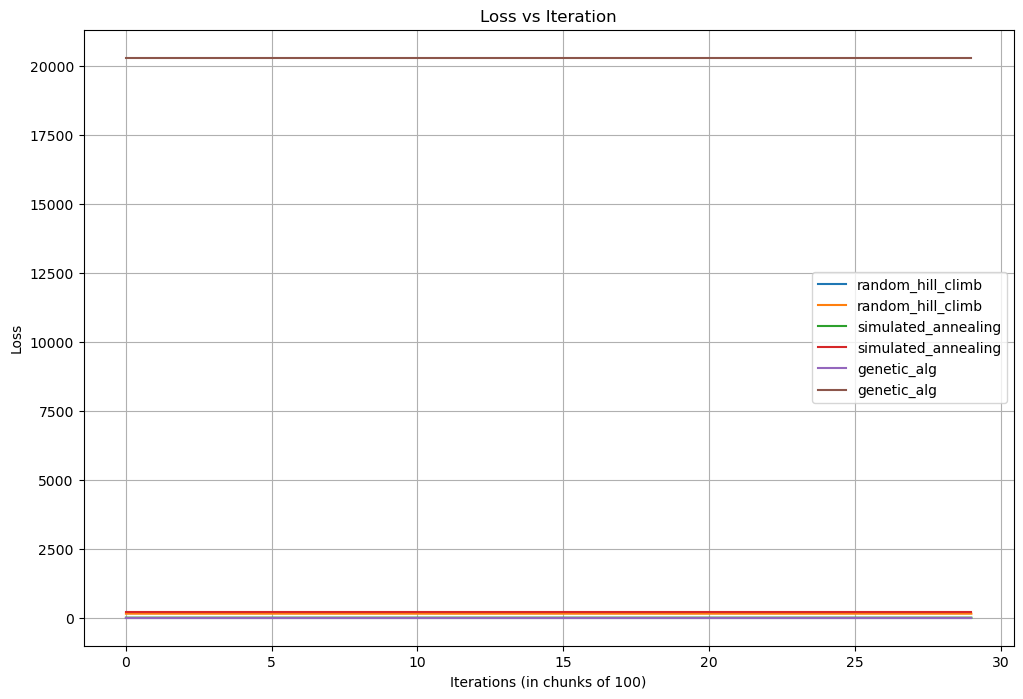

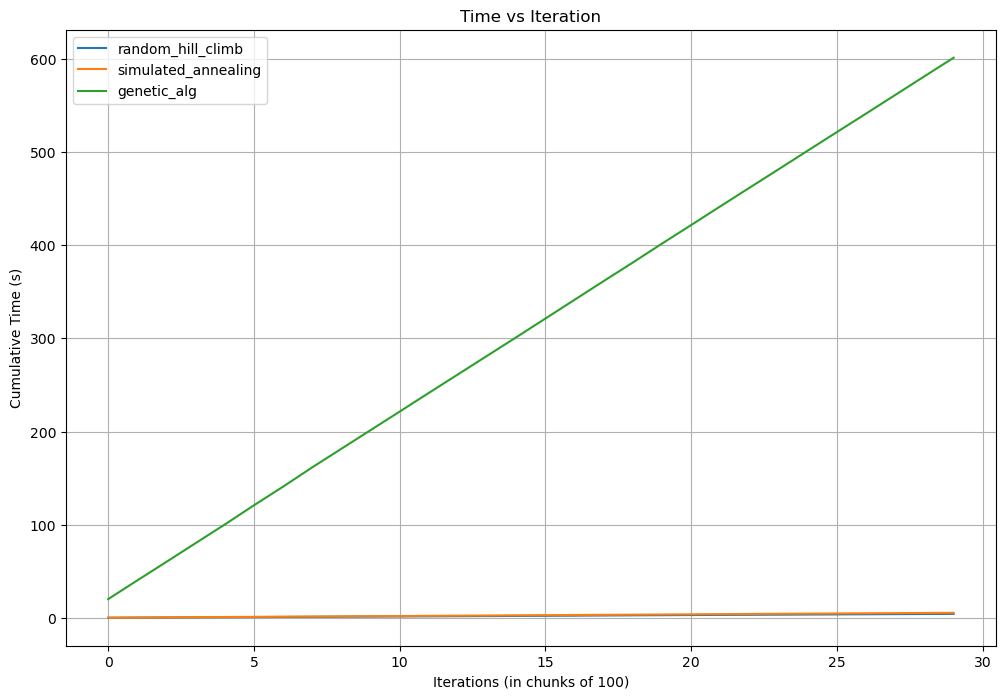


Results for random_hill_climb:
Accuracy: 0.4474
Precision: 0.3864
Recall: 0.7907
F1 Score: 0.5191
Training Time: 4.2863

Results for simulated_annealing:
Accuracy: 0.4474
Precision: 0.2368
Recall: 0.2093
F1 Score: 0.2222
Training Time: 5.4612

Results for genetic_alg:
Accuracy: 0.6228
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Training Time: 601.1222


In [9]:
# Defining the algorithms
algorithms = ["random_hill_climb", "simulated_annealing", "genetic_alg"]

# Schedule for simulated annealing (if needed)
schedule = GeomDecay()

# Store results and intermediate data for plots
results = {}
fitness_curves = {}
time_curves = {}
max_iters = 3000
step = 100

# Training and evaluation
for algo in algorithms:
    print(f"Training using {algo}...")
    
    times = []
    losses = []
    
    # Initialize weights before the loop
    initial_weights = np.random.randn(365)
    
    for i in range(0, max_iters, step):
        nn_model = NeuralNetwork(hidden_nodes=[10, 5], activation='relu',
                                 algorithm=algo, max_iters=step, bias=True, is_classifier=True,
                                 learning_rate=0.001, early_stopping=True, schedule=schedule,
                                 max_attempts=100, random_state=42, curve=True)
        
        # Timer start
        start_time = time.time()
        
        nn_model.fit(x_train_scaled, y_train, init_weights=initial_weights)
        
        # Timer end
        end_time = time.time()
        
        # Update weights for next iteration
        initial_weights = nn_model.fitted_weights
        
        times.append(end_time - start_time)
        # Assuming last loss value is the final for that iteration chunk
        losses.append(nn_model.fitness_curve[-1])
    
    # Storing time curves and losses
    time_curves[algo] = np.cumsum(times)
    fitness_curves[algo] = losses
    
    # Evaluation on validation set
    y_pred = nn_model.predict(x_valid_scaled)
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    
    results[algo] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Training Time": np.sum(times)
    }

# Plotting Loss vs Iteration
plt.figure(figsize=(12, 8))
for algo, curve in fitness_curves.items():
    plt.plot(curve, label=algo)
plt.xlabel("Iterations (in chunks of 100)")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Time vs Iteration
plt.figure(figsize=(12, 8))
for algo, curve in time_curves.items():
    plt.plot(curve, label=algo)
plt.xlabel("Iterations (in chunks of 100)")
plt.ylabel("Cumulative Time (s)")
plt.title("Time vs Iteration")
plt.legend()
plt.grid(True)
plt.show()

# Printing results
for algo, metrics in results.items():
    print(f"\nResults for {algo}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

Training using random_hill_climb...
Training using simulated_annealing...
Training using genetic_alg...


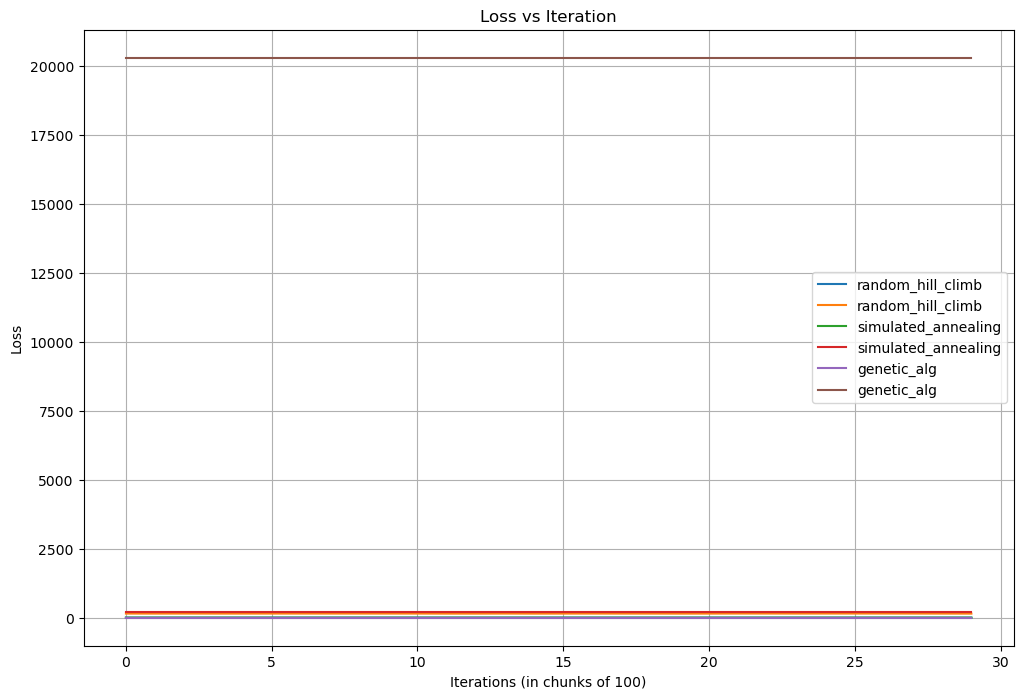

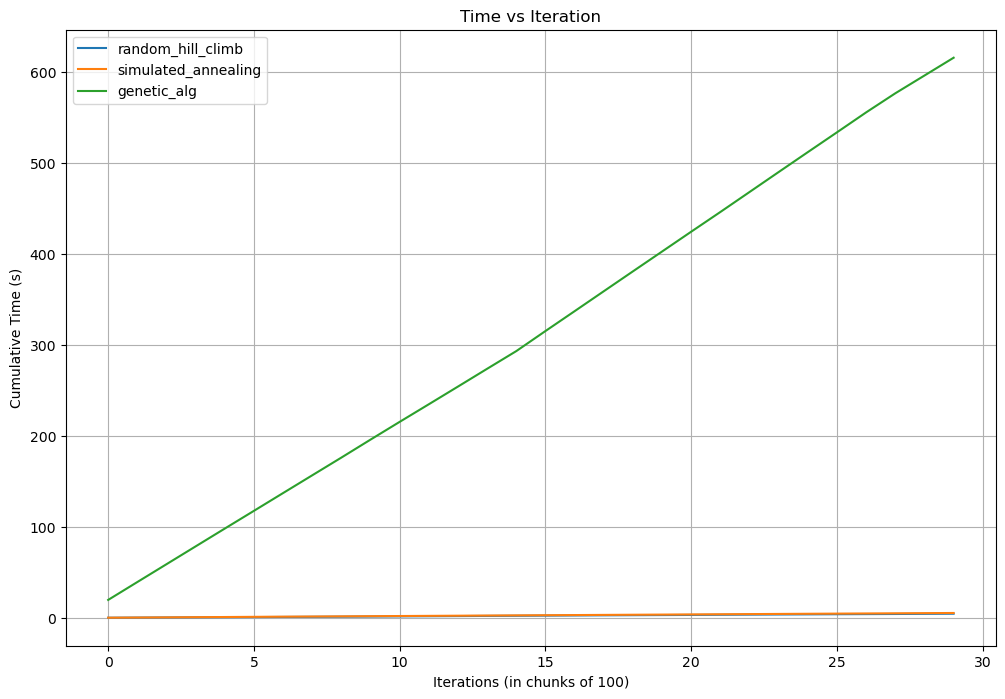

In [13]:
# Defining the algorithms
algorithms = ["random_hill_climb", "simulated_annealing", "genetic_alg"]

# Schedule for simulated annealing (if needed)
schedule = GeomDecay()

# Store results and intermediate data for plots
results = {}
fitness_curves = {}
time_curves = {}
max_iters = 3000
step = 100

# Training and evaluation
for algo in algorithms:
    print(f"Training using {algo}...")
    
    times = []
    losses = []
    
    # Initialize weights before the loop
    initial_weights = np.random.randn(365)


    
    for i in range(0, max_iters, step):
        nn_model = NeuralNetwork(hidden_nodes=[10, 5], activation='relu',
                                 algorithm=algo, max_iters=step, bias=True, is_classifier=True,
                                 learning_rate=0.001, early_stopping=True, schedule=schedule,
                                 max_attempts=100, random_state=42, curve=True)
        
        # Timer start
        start_time = time.time()
        
        nn_model.fit(x_train_scaled, y_train, init_weights=initial_weights)
        
        # Timer end
        end_time = time.time()
        
        # Update weights for next iteration
        initial_weights = nn_model.fitted_weights
        
        times.append(end_time - start_time)
        # Assuming last loss value is the final for that iteration chunk
        losses.append(nn_model.fitness_curve[-1])
    
    # Storing time curves and losses
    time_curves[algo] = np.cumsum(times)
    fitness_curves[algo] = losses
    
    # Evaluation on validation set
    y_pred = nn_model.predict(x_valid_scaled)
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    
    results[algo] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

# Plotting Loss vs Iteration
plt.figure(figsize=(12, 8))
for algo, curve in fitness_curves.items():
    plt.plot(curve, label=algo)
plt.xlabel("Iterations (in chunks of 100)")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Time vs Iteration
plt.figure(figsize=(12, 8))
for algo, curve in time_curves.items():
    plt.plot(curve, label=algo)
plt.xlabel("Iterations (in chunks of 100)")
plt.ylabel("Cumulative Time (s)")
plt.title("Time vs Iteration")
plt.legend()
plt.grid(True)
plt.show()

Training using random_hill_climb...
Training using simulated_annealing...
Training using genetic_alg...

Results for random_hill_climb:
Accuracy: 0.4035
Precision: 0.3853
Recall: 0.9767
F1 Score: 0.5526
Training Time: 4.5822

Results for simulated_annealing:
Accuracy: 0.3596
Precision: 0.3611
Recall: 0.9070
F1 Score: 0.5166
Training Time: 5.6194

Results for genetic_alg:
Accuracy: 0.8596
Precision: 1.0000
Recall: 0.6279
F1 Score: 0.7714
Training Time: 59.9805


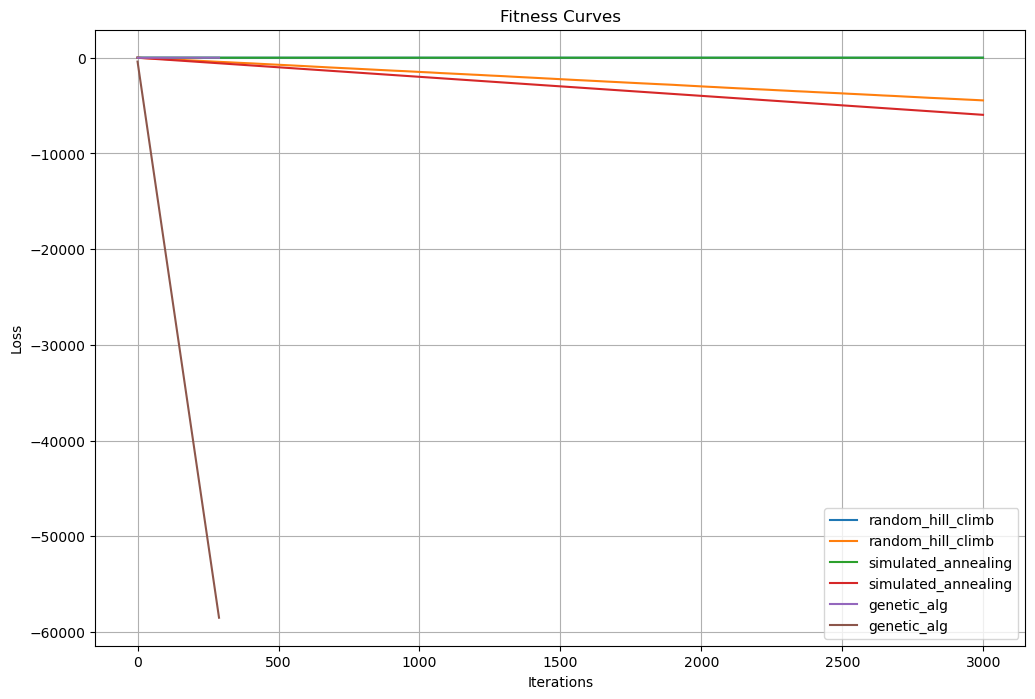

In [17]:
# Defining the algorithms
algorithms = ["random_hill_climb", "simulated_annealing", "genetic_alg"]

# Schedule for simulated annealing (if needed)
schedule = GeomDecay()

# Store results
results = {}
fitness_curves = {}

# Training and evaluation
for algo in algorithms:
    print(f"Training using {algo}...")
    
    # Timer start
    start_time = time.time()
    
    # Create and train NeuralNetwork
    nn_model = NeuralNetwork(hidden_nodes=[10, 5], activation='relu',
                             algorithm=algo, max_iters=3000, bias=True, is_classifier=True,
                             learning_rate=0.001, early_stopping=True, schedule=schedule,
                             max_attempts=100, random_state=42, curve=True)
    
    nn_model.fit(x_train_scaled, y_train)
    
    # Timer end
    end_time = time.time()
    
    # Collecting metrics
    y_pred = nn_model.predict(x_valid_scaled)
    
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    
    results[algo] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Training Time": end_time - start_time
    }
    
    # Storing fitness curves
    fitness_curves[algo] = nn_model.fitness_curve

# Printing results
for algo, metrics in results.items():
    print(f"\nResults for {algo}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Plotting
plt.figure(figsize=(12, 8))
for algo, curve in fitness_curves.items():
    plt.plot(-curve, label=algo)  # Negative because we typically want to minimize loss
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Fitness Curves")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Evaluation metrics storage
test_results = {}

for algo in algorithms:
    print(f"Evaluating model trained with {algo} on test set...")
    
    # Use the previously trained model
    y_test_pred = nn_model.predict(x_test_scaled)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    test_results[algo] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

# Display the results
for algo, metrics in test_results.items():
    print(f"\nResults for {algo}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Evaluating model trained with random_hill_climb on test set...
Evaluating model trained with simulated_annealing on test set...
Evaluating model trained with genetic_alg on test set...

Results for random_hill_climb:
Accuracy: 0.6316
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Results for simulated_annealing:
Accuracy: 0.6316
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Results for genetic_alg:
Accuracy: 0.6316
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000



Evaluating model trained with random_hill_climb on the test set...

Evaluating model trained with simulated_annealing on the test set...

Evaluating model trained with genetic_alg on the test set...

Test Metrics for random_hill_climb:
Accuracy: 0.3509
Precision: 0.3491
Recall: 0.8810
F1 Score: 0.5000
Confusion Matrix:
[[ 3 69]
 [ 5 37]]
Training Time: 4.8619 seconds

Test Metrics for simulated_annealing:
Accuracy: 0.3333
Precision: 0.3426
Recall: 0.8810
F1 Score: 0.4933
Confusion Matrix:
[[ 1 71]
 [ 5 37]]
Training Time: 6.4700 seconds

Test Metrics for genetic_alg:
Accuracy: 0.9386
Precision: 1.0000
Recall: 0.8333
F1 Score: 0.9091
Confusion Matrix:
[[72  0]
 [ 7 35]]
Training Time: 56.0030 seconds


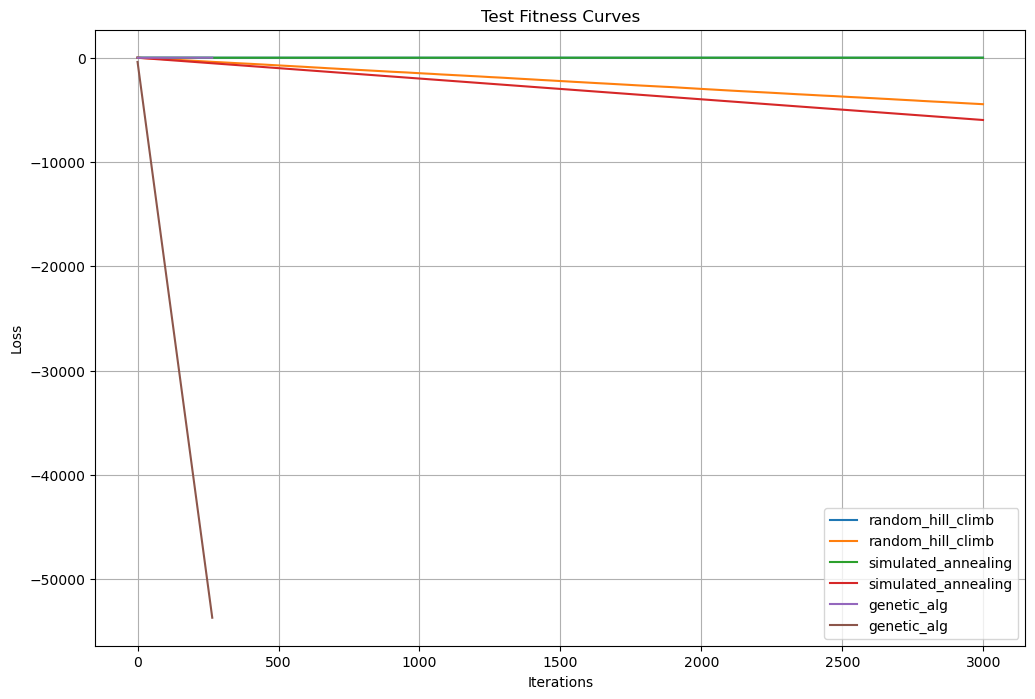

In [11]:
# Evaluate each algorithm on the test set
test_results = {}
time_curves_test = {}
fitness_curves_test = {}

for algo in algorithms:
    print(f"\nEvaluating model trained with {algo} on the test set...")

    # Initialize the model with the current algorithm
    nn_model = NeuralNetwork(hidden_nodes=[10, 5], activation='relu',
                             algorithm=algo, max_iters=3000, bias=True, is_classifier=True,
                             learning_rate=0.001, early_stopping=True, schedule=schedule,
                             max_attempts=100, random_state=42, curve=True)

    # Training the model on combined training and validation set
    x_combined = np.vstack((x_train_scaled, x_valid_scaled))
    y_combined = np.hstack((y_train, y_valid))
    
    # Start timing
    start_time = time.time()
    
    nn_model.fit(x_combined, y_combined)
    
    # End timing
    end_time = time.time()
    
    # Evaluation on the test set
    y_test_pred = nn_model.predict(x_test_scaled)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    confusion_test = confusion_matrix(y_test, y_test_pred)

    # Storing the metrics for the current algorithm
    test_results[algo] = {
        "Accuracy": accuracy_test,
        "Precision": precision_test,
        "Recall": recall_test,
        "F1 Score": f1_test,
        "Confusion Matrix": confusion_test,
        "Training Time": end_time - start_time
    }
    
    # Storing fitness curves
    fitness_curves_test[algo] = nn_model.fitness_curve

# Printing the metrics
for algo, metrics in test_results.items():
    print(f"\nTest Metrics for {algo}:")
    for metric, value in metrics.items():
        if metric == "Confusion Matrix":
            print(f"{metric}:\n{value}")
        elif metric == "Training Time":
            print(f"{metric}: {value:.4f} seconds")
        else:
            print(f"{metric}: {value:.4f}")

# Plotting fitness curves
plt.figure(figsize=(12, 8))
for algo, curve in fitness_curves_test.items():
    plt.plot(-curve, label=algo)  # Negative because we typically want to minimize loss
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Test Fitness Curves")
plt.legend()
plt.grid(True)
plt.show()

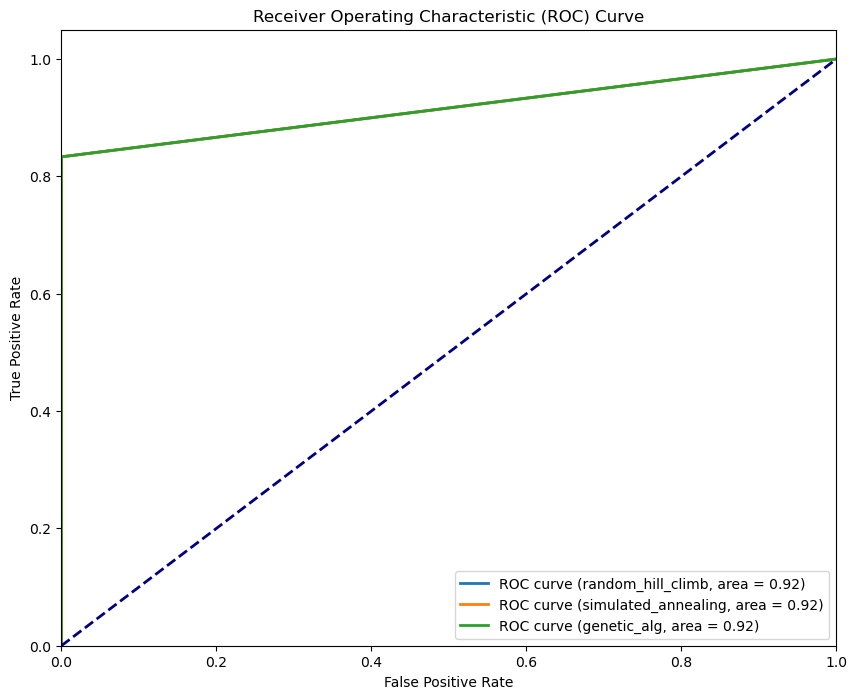

In [13]:
from sklearn.metrics import roc_curve, auc

# Initialize a figure
plt.figure(figsize=(10, 8))

for algo in algorithms:
    # Get the model's prediction for the test set
    y_test_pred = nn_model.predict(x_test_scaled)  # Use the right model here

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve ({algo}, area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

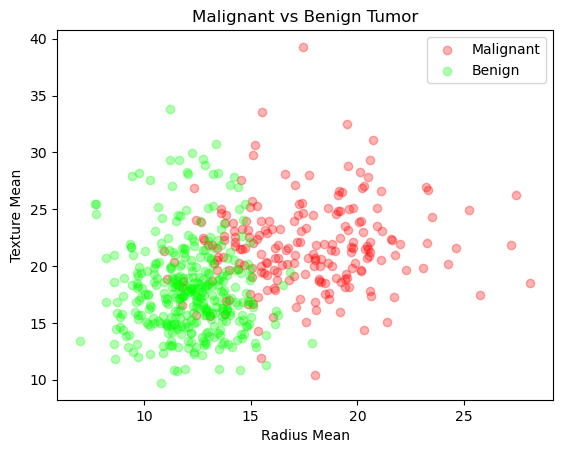


Test Metrics for random_hill_climb:
Accuracy: 0.3509
Precision: 0.3491
Recall: 0.8810
F1 Score: 0.5000
Confusion Matrix:
[[ 3 69]
 [ 5 37]]
Training Time: 4.8619 seconds

Test Metrics for simulated_annealing:
Accuracy: 0.3333
Precision: 0.3426
Recall: 0.8810
F1 Score: 0.4933
Confusion Matrix:
[[ 1 71]
 [ 5 37]]
Training Time: 6.4700 seconds

Test Metrics for genetic_alg:
Accuracy: 0.9386
Precision: 1.0000
Recall: 0.8333
F1 Score: 0.9091
Confusion Matrix:
[[72  0]
 [ 7 35]]
Training Time: 56.0030 seconds


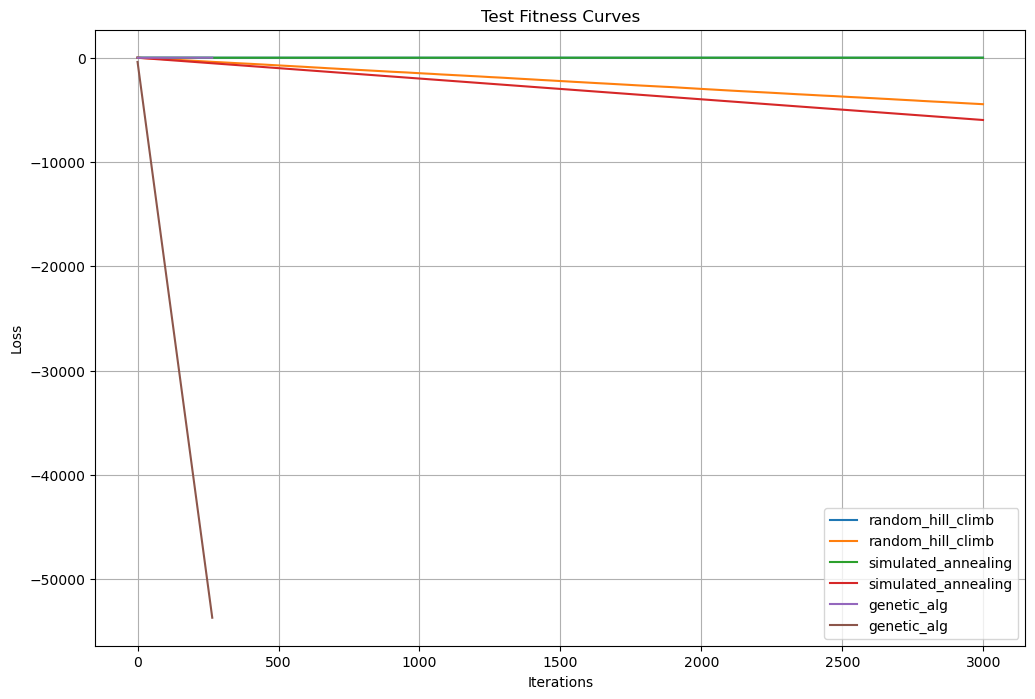

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


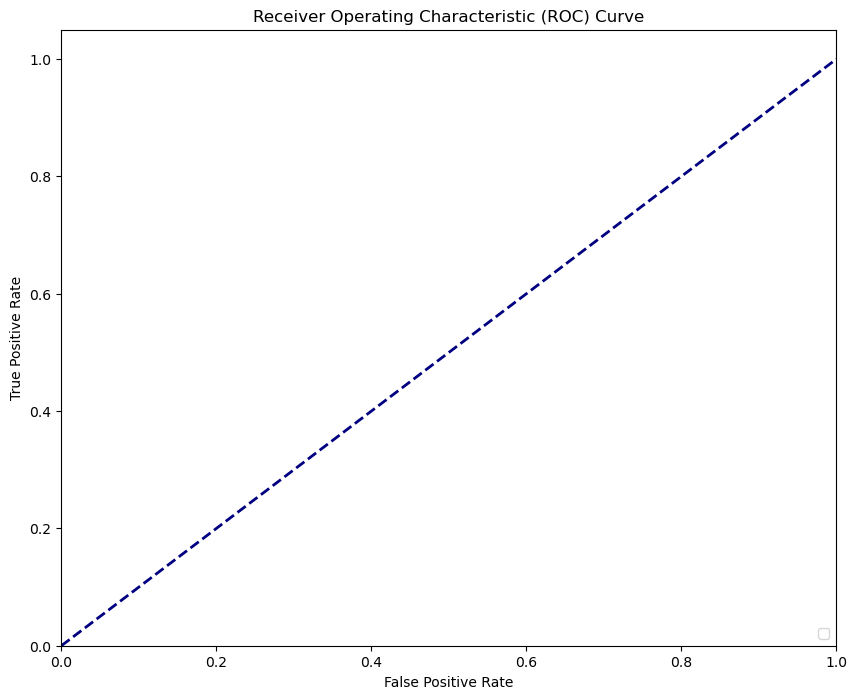


Evaluating model trained with random_hill_climb on the test set...

Evaluating model trained with simulated_annealing on the test set...

Evaluating model trained with genetic_alg on the test set...


In [21]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from mlrose_hiive import NeuralNetwork, GeomDecay
from sklearn.metrics import roc_curve, auc
from joblib import Parallel, delayed

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
dataset = pd.read_csv("data.csv")

# Data Visualization
def plot_data(df):
    M = df[df.diagnosis == "M"]
    B = df[df.diagnosis == "B"]
    plt.title("Malignant vs Benign Tumor")
    plt.xlabel("Radius Mean")
    plt.ylabel("Texture Mean")
    plt.scatter(M.radius_mean, M.texture_mean, color="red", label="Malignant", alpha=0.3)
    plt.scatter(B.radius_mean, B.texture_mean, color="lime", label="Benign", alpha=0.3)
    plt.legend()
    plt.show()

plot_data(dataset)

# Data Preprocessing
def preprocess_data(df):
    df = df.drop(["id", "Unnamed: 32"], axis=1)
    # Encode the target variable
    df.diagnosis = [1 if i == "M" else 0 for i in df.diagnosis]
    x = df.drop(["diagnosis"], axis=1)
    y = df.diagnosis.values
    return x, y

x, y = preprocess_data(dataset)

# Split the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42, stratify=y)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardize the datasets
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

# Define algorithms and schedule
algorithms = ["random_hill_climb", "simulated_annealing", "genetic_alg"]
schedule = GeomDecay()

# Parallel processing function for evaluating each algorithm on the test set
def evaluate_algorithm(algo):
    print(f"\nEvaluating model trained with {algo} on the test set...")

    # Initialize the model with the current algorithm
    nn_model = NeuralNetwork(hidden_nodes=[10, 5], activation='relu',
                             algorithm=algo, max_iters=3000, bias=True, is_classifier=True,
                             learning_rate=0.001, early_stopping=True, schedule=schedule,
                             max_attempts=100, random_state=42, curve=True)

    # Training the model on combined training and validation set
    x_combined = np.vstack((x_train_scaled, x_valid_scaled))
    y_combined = np.hstack((y_train, y_valid))
    
    # Start timing
    start_time = time.time()
    
    nn_model.fit(x_combined, y_combined)
    
    # End timing
    end_time = time.time()
    
    # Evaluation on the test set
    y_test_pred = nn_model.predict(x_test_scaled)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    confusion_test = confusion_matrix(y_test, y_test_pred)

    # Calculate ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)

    # Storing the metrics for the current algorithm
    test_results[algo] = {
        "Accuracy": accuracy_test,
        "Precision": precision_test,
        "Recall": recall_test,
        "F1 Score": f1_test,
        "Confusion Matrix": confusion_test,
        "Training Time": end_time - start_time,
        "ROC Curve": (fpr, tpr, roc_auc)
    }
    
    # Storing fitness curves
    fitness_curves_test[algo] = nn_model.fitness_curve

# Parallel processing for evaluating each algorithm
num_cores = len(algorithms)
Parallel(n_jobs=num_cores)(delayed(evaluate_algorithm)(algo) for algo in algorithms)

# Printing the metrics
for algo, metrics in test_results.items():
    print(f"\nTest Metrics for {algo}:")
    for metric, value in metrics.items():
        if metric == "Confusion Matrix":
            print(f"{metric}:\n{value}")
        elif metric == "ROC Curve":
            print(f"{metric} (AUC): {value[2]:.4f}")
        elif metric == "Training Time":
            print(f"{metric}: {value:.4f} seconds")
        else:
            print(f"{metric}: {value:.4f}")

# Plotting fitness curves
plt.figure(figsize=(12, 8))
for algo, curve in fitness_curves_test.items():
    plt.plot(-curve, label=algo)  # Negative because we typically want to minimize loss
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Test Fitness Curves")
plt.legend()
plt.grid(True)
plt.show()

# Plotting ROC curves if available
plt.figure(figsize=(10, 8))
for algo, roc_data in test_results.items():
    if "ROC Curve" in roc_data:
        fpr, tpr, roc_auc = roc_data["ROC Curve"]
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve ({algo}, area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [22]:
# Plotting ROC curves if available
plt.figure(figsize=(10, 8))
for algo, roc_data in test_results.items():
    if "ROC Curve" in roc_data:
        fpr, tpr, roc_auc = roc_data["ROC Curve"]
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve ({algo}, area = {roc_auc:.2f})')

if any("ROC Curve" in roc_data for roc_data in test_results.values()):
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("No ROC data available for some algorithms.")

No ROC data available for some algorithms.


<Figure size 1000x800 with 0 Axes>

In [24]:
# Evaluate each algorithm on the test set
test_results = {}
time_curves_test = {}
fitness_curves_test = {}

for algo in algorithms:
    print(f"\nEvaluating model trained with {algo} on the test set...")

    # Initialize the model with the current algorithm
    nn_model = NeuralNetwork(hidden_nodes=[10, 5], activation='relu',
                             algorithm=algo, max_iters=3000, bias=True, is_classifier=True,
                             learning_rate=0.001, early_stopping=True, schedule=schedule,
                             max_attempts=100, random_state=42, curve=True)

    # Training the model on combined training and validation set
    x_combined = np.vstack((x_train_scaled, x_valid_scaled))
    y_combined = np.hstack((y_train, y_valid))
    
    # Start timing
    start_time = time.time()
    
    nn_model.fit(x_combined, y_combined)
    
    # End timing
    end_time = time.time()
    
    # Evaluation on the test set
    y_test_pred = nn_model.predict(x_test_scaled)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    confusion_test = confusion_matrix(y_test, y_test_pred)

    # Calculate ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)

    # Storing the metrics and ROC data for the current algorithm
    test_results[algo] = {
        "Accuracy": accuracy_test,
        "Precision": precision_test,
        "Recall": recall_test,
        "F1 Score": f1_test,
        "Confusion Matrix": confusion_test,
        "Training Time": end_time - start_time,
        "ROC Curve": (fpr, tpr, roc_auc)
    }
    
    # Storing fitness curves
    fitness_curves_test[algo] = nn_model.fitness_curve

# Printing the metrics
for algo, metrics in test_results.items():
    print(f"\nTest Metrics for {algo}:")
    for metric, value in metrics.items():
        if metric == "Confusion Matrix":
            print(f"{metric}:\n{value}")
        elif metric == "Training Time":
            print(f"{metric}: {value:.4f} seconds")
        elif metric == "ROC Curve":
            fpr, tpr, roc_auc = value
            print(f"ROC AUC ({algo}): {roc_auc:.4f}")
        else:
            print(f"{metric}: {value:.4f}")


Evaluating model trained with random_hill_climb on the test set...

Evaluating model trained with simulated_annealing on the test set...

Evaluating model trained with genetic_alg on the test set...

Test Metrics for random_hill_climb:
Accuracy: 0.3509
Precision: 0.3491
Recall: 0.8810
F1 Score: 0.5000
Confusion Matrix:
[[ 3 69]
 [ 5 37]]
Training Time: 5.2806 seconds
ROC AUC (random_hill_climb): 0.4613

Test Metrics for simulated_annealing:
Accuracy: 0.3333
Precision: 0.3426
Recall: 0.8810
F1 Score: 0.4933
Confusion Matrix:
[[ 1 71]
 [ 5 37]]
Training Time: 6.3627 seconds
ROC AUC (simulated_annealing): 0.4474

Test Metrics for genetic_alg:
Accuracy: 0.9386
Precision: 1.0000
Recall: 0.8333
F1 Score: 0.9091
Confusion Matrix:
[[72  0]
 [ 7 35]]
Training Time: 61.5820 seconds
ROC AUC (genetic_alg): 0.9167


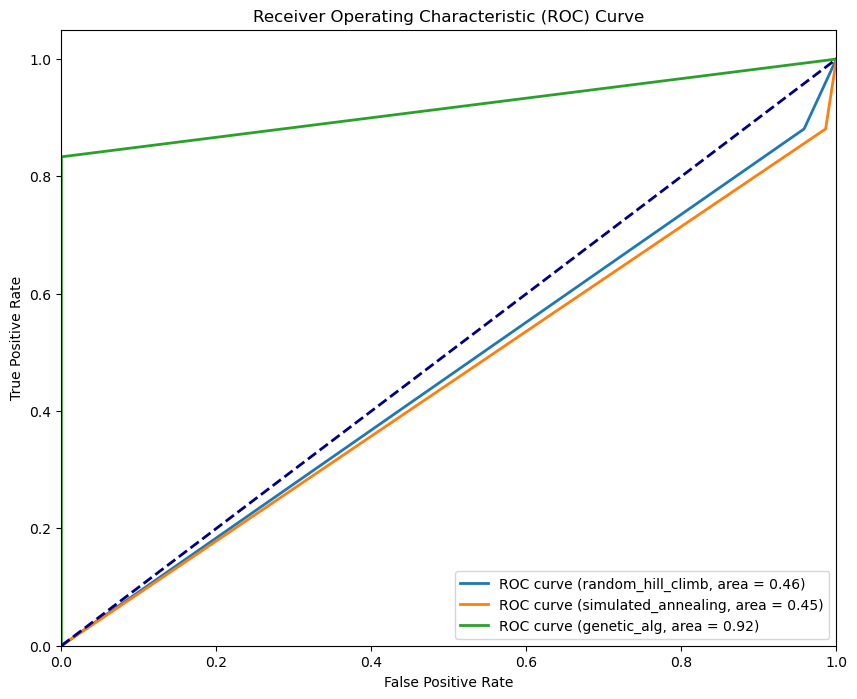

In [25]:
# Plot ROC curves if available
plt.figure(figsize=(10, 8))
for algo, metrics in test_results.items():
    if "ROC Curve" in metrics:
        fpr, tpr, roc_auc = metrics["ROC Curve"]
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve ({algo}, area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()